In [2]:

import bert_score
import evaluate
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

c:\Users\zakit\Documents\COMP0087 CW\COMP0087-Group\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Device being used: cuda


In [3]:

bleurt = evaluate.load("bleurt", module_type='metric')

Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').



INFO:tensorflow:Reading checkpoint C:\Users\zakit\.cache\huggingface\metrics\bleurt\default\downloads\extracted\b54c9e3ed7a119fa086f7140485aad9e6d00893d772ae11ef5b23380d37fd436\bleurt-base-128.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:128
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.

INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [33]:
import ast
import pandas as pd

bleu = evaluate.load('bleu')

def icl_results(icl_method, ds_name, model_name):
    results_data=[]
    with open(f'icl_results/outputs/{icl_method}_{ds_name}_{model_name}.txt', 'r', encoding='utf-8') as file:
        # Read lines from the file
        lines = file.readlines()
        print(len(lines))
        i=0
        # Iterate through lines
        while i < len(lines)-1: # Assuming that every 3 lines correspond to one iteration
            # Extract real values and predictions and append them to the respective lists
            preds = ast.literal_eval(lines[i+1][11:])
            reals = ast.literal_eval(lines[i][11:])
            print(reals)
            print(preds)
            P, R, F1 = bert_score.score(preds, reals, lang="en")
            average_F1 = sum(F1) / len(F1)
            # bert_scores.append(average_F1)
            refs = [[r] for r in reals]
            bleu_score = bleu.compute(predictions=preds, references=refs, max_order=1)
            bleu_score2 = bleu.compute(predictions=preds, references=refs, max_order = 2)
            bleu_score4 = bleu.compute(predictions=preds, references=refs)

            # accuracy = 0
            # for r,p in zip(reals, preds):
            #     if len(p.strip()) != 0:
            #         if r.strip()[0] == p.strip()[0]:
            #             accuracy+=1
            # accuracy = accuracy/len(preds)
            # print("ACCURACY (comparing first letter): ", accuracy)

            # accuracy = 0
            # for r,p in zip(reals, preds):
            #     if p.strip()==r.strip():
            #         accuracy+=1
            # accuracy = accuracy/len(preds)
            # print("ACCURACY (exact) ", accuracy)

            bleurt_score = bleurt.compute(predictions=preds, references=reals)
            avg_bleurt = sum(bleurt_score['scores'])/len(bleurt_score['scores'])
            results_data.append({'num_samples' : len(preds), 'num_demonstrations' : i//3, 'bert_score' : float(average_F1), 'bleu-1' : bleu_score['bleu'], 'bleu-2':bleu_score2['bleu'],
                                'bleu-4':bleu_score4['bleu'], 'bleurt' : avg_bleurt})
            i+=3

    results_df1 = pd.DataFrame(results_data)
    return results_df1

def it_results(ds_name, model_name):

    results_data = []

    # Open the file containing the real values and predictions
    with open(f'it_results/outputs/{ds_name}_{model_name}_it.txt', 'r', encoding='utf-8') as file:
        # Read lines from the file
        lines = file.readlines()
        print(len(lines))
        i=0
        while i < len(lines)-1: # Assuming that every 3 lines correspond to one iteration
            # Extract real values and predictions and append them to the respective lists
            preds = ast.literal_eval(lines[i+1][11:])
            reals = ast.literal_eval(lines[i][11:])
            print(reals)
            print(preds)
            P, R, F1 = bert_score.score(preds, reals, lang="en")
            average_F1 = sum(F1) / len(F1)
            # bert_scores.append(average_F1)
            refs = [[r] for r in reals]
            order = int(sum(len(s) for s in refs)/len(refs))
            bleu_score = bleu.compute(predictions=preds, references=refs, max_order=1)
            bleu_score2 = bleu.compute(predictions=preds, references=refs, max_order = 2)
            bleu_score4 = bleu.compute(predictions=preds, references=refs)
            # rouge_score = rouge.compute(predictions=preds, references=refs)
            
            # accuracy = 0
            # for r,p in zip(reals, preds):
            #     if len(p.strip()) != 0:
            #         if r.strip()[0] == p.strip()[0]:
            #             accuracy+=1
            # accuracy = accuracy/len(preds)
            # print("ACCURACY (comparing first letter): ", accuracy)

            # accuracy = 0
            # for r,p in zip(reals, preds):
            #     if p.strip()==r.strip():
            #         accuracy+=1
            # accuracy = accuracy/len(preds)
            # print("ACCURACY (exact) ", accuracy)

            bleurt_score = bleurt.compute(predictions=preds, references=reals)
            avg_bleurt = sum(bleurt_score['scores'])/len(bleurt_score['scores'])
            results_data.append({'num_samples' : len(preds), 'num_demonstrations' : None, 'bert_score' : float(average_F1), 'bleu-1' : bleu_score['bleu'], 'bleu-2':bleu_score2['bleu'], 
                                'bleu-4':bleu_score4['bleu'], 'bleurt':avg_bleurt})
            i+=3

    results_df2 = pd.DataFrame(results_data)
    return results_df2

datasets = ['ni', 'alpaca', 'medmcq','finance_sent', 'medqa', 'lawqa']
# icl_dfs = []
# for d in datasets:
#     df1 = icl_results('random', d, 'gpt2_small')
#     df1['dataset'] = d
#     icl_dfs.append(df1)
# big_icl_df = pd.concat(icl_dfs, axis=0)

icl_dfs = []
for d in datasets:
    df1 = icl_results('similarity', d, 'gpt2_small')
    df1['dataset'] = d
    icl_dfs.append(df1)
big_icl_df2 = pd.concat(icl_dfs, axis=0)

9
['no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'unicycle', 'salad', 'fuel', 'fox', 'dress', 'lease', 'remedy', 'field', 'orders', 'mountain', 'after watching the movie kelly began to work on her own story. the _ was for her job.', 'because of the large amount of snow that fell, james had to shovel it off his car before he could go to work. the _ was needed for his job.', 'mike used a new notebook for his notes instead of his notepad, since the _ was full .', 'the rats fled their holes for the open spaces since the _ were roomy for them.', 'the dish had the peppers removed and replaced by mushrooms to accommodate the bland tastes of the customers, as _ were mild .', 'jane chose to write about dolphins instead of bears for her thesis, although _ were her strongest area of expertise.', 'the swamp was a good home for the alligator because _ needed a watery environment.', 'the parent chose the daughter over the son for the inheritance, since _ showed more negl

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'unicycle', 'salad', 'fuel', 'fox', 'dress', 'lease', 'remedy', 'field', 'orders', 'mountain', 'after watching the movie kelly began to work on her own story. the _ was for her job.', 'mike used a new notebook for his notes instead of his notepad, since the _ was full .', 'the rats fled their holes for the open spaces since the _ were roomy for them.', 'the dish had the peppers removed and replaced by mushrooms to accommodate the bland tastes of the customers, as _ were mild .', 'jane chose to write about dolphins instead of bears for her thesis, although _ were her strongest area of expertise.', 'the swamp was a good home for the alligator because _ needed a watery environment.', 'the parent chose the daughter over the son for the inheritance, since _ showed more negligence .', "the babies' little hands could not fit through the slats in the crib, because _ were too narrow.", 'todd chose the job at the office 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'no.', 'yes.', 'unicycle', 'salad', 'fuel', 'fox', 'dress', 'lease', 'remedy', 'field', 'orders', 'mountain', "personx learned new organizational skills from persony because _ 's day schedule was very efficient.", 'personx gave valuable pre-natal advice to persony since _ had no experience with coping with pregnancy.', 'personx was accepted by persony for her club, so _ had a new member at last.', 'personx had been abused badly by persony , so the pain _ gave was recurring every day.', 'personx was no longer interested in working for persony , so _ accepted her notice to resign.', 'personx caught more fish than persony , so _ was disappointed with their fishing trip.', 'personx gave lessons to persony , as _ had so little piano playing knowledge and experience.', 'personx acted superior and confident around persony , since _ had much too low self-esteem.', 'personx declined to invite  persony to go on a long hike, as _ prefer

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


9
['the technical term for the "high-pitched, ringing sound" a person may hear due to prolonged exposure to loud noise is tinnitus.', 'text a and text b contrast in their opinion of the cost of living in the past decade. text a states that the cost of living has increased significantly while text b claims that the cost of living has decreased significantly.', 'la vida es un viaje (spanish).', 'unnecessary.', 'it is my opinion that this course of action will not prove to be successful.', 'nobody revisits rome.', 'two obstacles to successful communication are communication style differences and lack of clarity. communication style differences occur when two people have different ideas as to how to effectively communicate, such as one person preferring more direct conversation and the other preferring more subtle conversation, leading to miscommunication. lack of clarity occurs when a person is not clear in their communication, leading to confusion or misinterpretation.', 'scaffold', 'i s

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['the technical term for the "high-pitched, ringing sound" a person may hear due to prolonged exposure to loud noise is tinnitus.', 'text a and text b contrast in their opinion of the cost of living in the past decade. text a states that the cost of living has increased significantly while text b claims that the cost of living has decreased significantly.', 'la vida es un viaje (spanish).', 'unnecessary.', 'it is my opinion that this course of action will not prove to be successful.', 'nobody revisits rome.', 'two obstacles to successful communication are communication style differences and lack of clarity. communication style differences occur when two people have different ideas as to how to effectively communicate, such as one person preferring more direct conversation and the other preferring more subtle conversation, leading to miscommunication. lack of clarity occurs when a person is not clear in their communication, leading to confusion or misinterpretation.', 'scaffold', 'i saw

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['the technical term for the "high-pitched, ringing sound" a person may hear due to prolonged exposure to loud noise is tinnitus.', 'text a and text b contrast in their opinion of the cost of living in the past decade. text a states that the cost of living has increased significantly while text b claims that the cost of living has decreased significantly.', 'la vida es un viaje (spanish).', 'unnecessary.', 'it is my opinion that this course of action will not prove to be successful.', 'nobody revisits rome.', 'two obstacles to successful communication are communication style differences and lack of clarity. communication style differences occur when two people have different ideas as to how to effectively communicate, such as one person preferring more direct conversation and the other preferring more subtle conversation, leading to miscommunication. lack of clarity occurs when a person is not clear in their communication, leading to confusion or misinterpretation.', 'scaffold', 'i saw

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


9
['d: hypercoagulable state', 'b: gaa', 'c: breakdown of endothelial tight junctions', 'e: cor pulmonale', 'e: begin cognitive behavioral therapy', 'd: iv acyclovir', 'b: discoid lupus erythematosus (dle)', 'd: low urine sodium', 'c: herpes simplex virus', 'd: ct scan of the head', 'd: enterocele', 'c: lysyl oxidase', 'c: ventricular septal defect (vsd)', 'e: replication of the attenuated vaccine strain', 'd: pick bodies', 'b: small cell lung carcinoma', 'a: 99mtc sestamibi scan with ultrasound of the neck', 'e: terminal bronchioles', 'd: carotid stenting', 'b: rotator cuff tear', 'a: ct scan', 'b: calcitriol', 'd: hemangioblastoma', 'e: hla-dr4', 'a: autosomal dominant polycystic kidney disease (adpkd)', 'a: posterior midline of the anal canal, distal to the pectinate line', 'a: ↑ nadh/nad+; ast:alt ≥ 2:1; ß-oxidation ↓; ß-hydroxybutyrate ↑; lactic acid ↑', 'a: decreased ph', 'c: chronic obstructive pulmonary disease', 'a: achlorhydria', 'a: mesenteric angiography', 'e: nm receptors 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['d: hypercoagulable state', 'b: gaa', 'c: breakdown of endothelial tight junctions', 'e: cor pulmonale', 'e: begin cognitive behavioral therapy', 'd: iv acyclovir', 'b: discoid lupus erythematosus (dle)', 'd: low urine sodium', 'c: herpes simplex virus', 'd: ct scan of the head', 'd: enterocele', 'c: lysyl oxidase', 'c: ventricular septal defect (vsd)', 'e: replication of the attenuated vaccine strain', 'd: pick bodies', 'b: small cell lung carcinoma', 'a: 99mtc sestamibi scan with ultrasound of the neck', 'e: terminal bronchioles', 'd: carotid stenting', 'b: rotator cuff tear', 'a: ct scan', 'b: calcitriol', 'd: hemangioblastoma', 'e: hla-dr4', 'a: autosomal dominant polycystic kidney disease (adpkd)', 'a: posterior midline of the anal canal, distal to the pectinate line', 'a: ↑ nadh/nad+; ast:alt ≥ 2:1; ß-oxidation ↓; ß-hydroxybutyrate ↑; lactic acid ↑', 'a: decreased ph', 'c: chronic obstructive pulmonary disease', 'a: achlorhydria', 'a: mesenteric angiography', 'e: nm receptors of

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['d: hypercoagulable state', 'b: gaa', 'c: breakdown of endothelial tight junctions', 'e: cor pulmonale', 'e: begin cognitive behavioral therapy', 'd: iv acyclovir', 'b: discoid lupus erythematosus (dle)', 'd: low urine sodium', 'c: herpes simplex virus', 'd: ct scan of the head', 'd: enterocele', 'c: lysyl oxidase', 'c: ventricular septal defect (vsd)', 'e: replication of the attenuated vaccine strain', 'd: pick bodies', 'b: small cell lung carcinoma', 'a: 99mtc sestamibi scan with ultrasound of the neck', 'e: terminal bronchioles', 'd: carotid stenting', 'b: rotator cuff tear', 'a: ct scan', 'b: calcitriol', 'd: hemangioblastoma', 'a: autosomal dominant polycystic kidney disease (adpkd)', 'a: posterior midline of the anal canal, distal to the pectinate line', 'a: ↑ nadh/nad+; ast:alt ≥ 2:1; ß-oxidation ↓; ß-hydroxybutyrate ↑; lactic acid ↑', 'a: decreased ph', 'c: chronic obstructive pulmonary disease', 'a: achlorhydria', 'a: mesenteric angiography', 'e: nm receptors of the quadricep

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


9
['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', '

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'ne

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'ne

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
9
["a:as a parent, it's distressing to hear that your child's safety is at risk. if the school is not addressing your concerns adequately, you might consider taking legal action. schools have a duty to provide a safe environment for students. you can request the surveillance footage formally through a written request; if the school refuses, this may be something that can be compelled through legal means. document all interactions with the school regarding this issue. it would be prudent to consult with an attorney who handles education law to explore the possibility of a lawsuit for failing to provide a safe environment for your child. they can guide you on how to proceed with obtaining evidence and how to protect your son's rights. ensure that your son's experiences are also recorded, as his account may be crucial for any legal action.", "a:you need to schedule a consultation with an attorney to evaluate all the facts and related communications. the action against you may or may not

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


["a:as a parent, it's distressing to hear that your child's safety is at risk. if the school is not addressing your concerns adequately, you might consider taking legal action. schools have a duty to provide a safe environment for students. you can request the surveillance footage formally through a written request; if the school refuses, this may be something that can be compelled through legal means. document all interactions with the school regarding this issue. it would be prudent to consult with an attorney who handles education law to explore the possibility of a lawsuit for failing to provide a safe environment for your child. they can guide you on how to proceed with obtaining evidence and how to protect your son's rights. ensure that your son's experiences are also recorded, as his account may be crucial for any legal action.", "a:you need to schedule a consultation with an attorney to evaluate all the facts and related communications. the action against you may or may not be 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


["a:as a parent, it's distressing to hear that your child's safety is at risk. if the school is not addressing your concerns adequately, you might consider taking legal action. schools have a duty to provide a safe environment for students. you can request the surveillance footage formally through a written request; if the school refuses, this may be something that can be compelled through legal means. document all interactions with the school regarding this issue. it would be prudent to consult with an attorney who handles education law to explore the possibility of a lawsuit for failing to provide a safe environment for your child. they can guide you on how to proceed with obtaining evidence and how to protect your son's rights. ensure that your son's experiences are also recorded, as his account may be crucial for any legal action.", "a:you need to schedule a consultation with an attorney to evaluate all the facts and related communications. the action against you may or may not be 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
big_icl_df.head(100)

,num_samples,num_demonstrations,bert_score,bleu-1,bleu-2,bleu-4,bleurt,dataset
0,100,0,0.815431,0.042714,0.029922,0.020676,-1.720041,ni
1,100,1,0.822408,0.030177,0.018125,0.010393,-1.715024,ni
2,100,2,0.831194,0.031719,0.019239,0.012215,-1.701236,ni
0,100,0,0.792627,0.086260,0.035738,0.014320,-1.354345,alpaca
1,100,1,0.817363,0.109225,0.049006,0.019412,-1.201671,alpaca
2,100,2,0.827631,0.127780,0.060643,0.024165,-1.033769,alpaca
0,100,0,0.809000,0.033282,0.018733,0.011394,-1.527328,medmcq
1,100,1,0.834986,0.041211,0.030190,0.020759,-1.662306,medmcq
2,100,2,0.831267,0.039899,0.028849,0.019745,-1.667960,medmcq
0,99,0,0.784238,0.000281,0.000000,0.000000,-1.904313,finance_sent


In [6]:
big_icl_df.drop(['dataset'], axis=1).groupby('num_demonstrations').agg('mean').head(100)

,num_samples,bert_score,bleu-1,bleu-2,bleu-4,bleurt
num_demonstrations,,,,,,
0,99.833333,0.810097,0.092861,0.040518,0.013893,-1.344487
1,99.833333,0.822649,0.096902,0.044933,0.017678,-1.349979
2,99.833333,0.825134,0.098951,0.045049,0.016296,-1.322539


In [34]:
big_icl_df2.head(100)

,num_samples,num_demonstrations,bert_score,bleu-1,bleu-2,bleu-4,bleurt,dataset
0,100.0,0.0,0.793343,0.018747,0.009894,0.005949,-1.345676,ni
1,99.0,1.0,0.811527,0.022409,0.007909,0.003397,-1.667490,ni
2,90.0,2.0,0.814386,0.016415,0.005734,0.002728,-1.735850,ni
0,100.0,0.0,0.750943,0.032483,0.019562,0.010521,-1.195199,alpaca
1,100.0,1.0,0.802797,0.080906,0.041316,0.019690,-1.034847,alpaca
2,100.0,2.0,0.801133,0.079395,0.038531,0.016451,-0.980967,alpaca
0,100.0,0.0,0.799909,0.021205,0.011451,0.004769,-1.224787,medmcq
1,100.0,1.0,0.827757,0.032385,0.022117,0.012503,-1.604216,medmcq
2,96.0,2.0,0.830471,0.033494,0.023229,0.013458,-1.609363,medmcq
0,98.0,0.0,0.685291,0.000000,0.000000,0.000000,-0.924758,finance_sent


In [35]:
big_icl_df2.drop(['dataset'], axis=1).groupby('num_demonstrations').agg('mean').head(100)

,num_samples,bert_score,bleu-1,bleu-2,bleu-4,bleurt
num_demonstrations,,,,,,
0.0,99.6,0.765327,0.037697,0.015964,0.006349,-1.131314
1.0,99.2,0.807985,0.055501,0.026881,0.012629,-1.333255
2.0,96.4,0.807805,0.054159,0.026003,0.011937,-1.334004


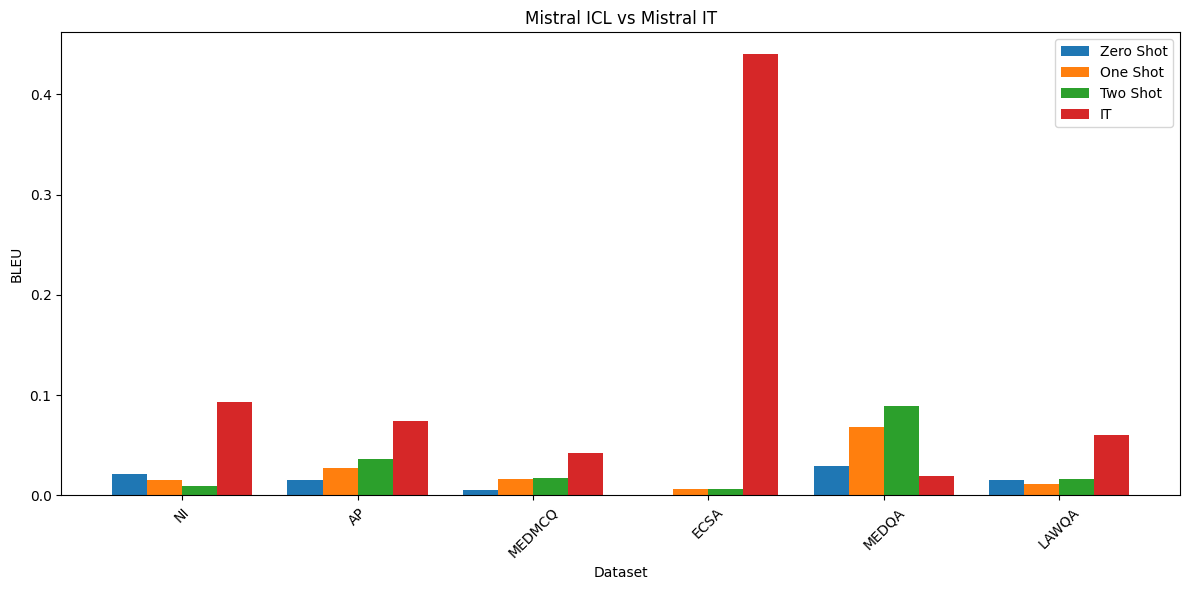

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for each num_demonstrations category
zero_shot = big_icl_df2[big_icl_df2['num_demonstrations'] == 0]
one_shot = big_icl_df2[big_icl_df2['num_demonstrations'] == 1]
two_shot = big_icl_df2[big_icl_df2['num_demonstrations'] == 2]


big_icl_df2.loc[(big_icl_df2['dataset'] == 'finance_sent') & (big_icl_df2['num_demonstrations'] == 0), 'bleu-4'] = 0.0
big_icl_df2.loc[(big_icl_df2['dataset'] == 'finance_sent') & (big_icl_df2['num_demonstrations'] == 1), 'bleu-4'] = 0.006
big_icl_df2.loc[(big_icl_df2['dataset'] == 'finance_sent') & (big_icl_df2['num_demonstrations'] == 2), 'bleu-4'] = 0.006

var = 'bleu-4'


# Define 'it' scores
# it = {'ni': 0.878, 'alpaca': 0.883, 'medmcq': 0.859, 'finance_sent':0.949, 'medqa': 0.851, 'lawqa': 0.859} #bert
# it = {'ni': 0.093, 'alpaca': 0.074, 'medmcq': 0.042, 'finance_sent':0.440, 'medqa': 0.019, 'lawqa': 0.06} #bleu
it =  {'ni': 0.016, 'alpaca': 0.064, 'medmcq': 0.002, 'finance_sent':0.130, 'medqa': 0.005, 'lawqa': 0.018} #bleu gpt2ap

datasets = zero_shot['dataset'].unique()
it_scores = pd.Series(it).reindex(datasets)

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2  # Width of the bars

# Position for the bars
x = range(len(datasets))

# Plot 'zero_shot' scores
ax.bar(x, zero_shot.groupby('dataset')[var].mean().reindex(datasets), width, label='Zero Shot')

# Plot 'one_shot' scores
ax.bar([i + width for i in x], one_shot.groupby('dataset')[var].mean().reindex(datasets), width, label='One Shot')

# Plot 'two_shot' scores
ax.bar([i + 2*width for i in x], two_shot.groupby('dataset')[var].mean().reindex(datasets), width, label='Two Shot')

# Plot 'it' scores with adjusted x positions
ax.bar([i + 3*width for i in x], it_scores, width, label='IT')

# Add labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('BLEU')
ax.set_title('Mistral ICL vs Mistral IT')
ax.set_xticks([i + 1.5*width for i in x])
ax.set_xticklabels(datasets)

category_labels = ['NI', 'AP', 'MEDMCQ', 'ECSA', 'MEDQA', 'LAWQA']  # Adjust labels as needed
ax.set_xticklabels(category_labels)

ax.legend()

# ax.set_yscale('log')

# Display plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() 
plt.savefig('mistral_bleu-1.png') # Adjust layout to prevent labels from overlapping
plt.show()
